In [1]:
import torch
torch.cuda.empty_cache()


* Özellikle notebook’ta yeniden çalıştırmadan önce kullanın.

---

## ⚙️ 1️⃣ Model Tipi: Encoder–Decoder (Seq2Seq LLM)

### Bu yapıda:

* Encoder, girdiyi (örneğin bir cümle veya belge) gizil temsile dönüştürür.

* Decoder, bu temsilden yeni bir metin üretir (çeviri, özet, yanıt, açıklama vb.).

* Yani Encoder = “Anla”, Decoder = “Anlattır”.

----

# Veri Setini inceleyelim

> ### Veri seti HuggingFace sitesinden alınmıştır : "https://huggingface.co/datasets/Renicames/turkish-law-chatbot"

In [2]:
from datasets import load_dataset

ds = load_dataset("Renicames/turkish-law-chatbot")

c:\Users\hdgn5\.conda\envs\torch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Veri setini yükle
from datasets import load_dataset
ds = load_dataset("Renicames/turkish-law-chatbot")

# Eğitim kısmını al
train_data = ds["train"]

# HuggingFace veri setinde sütun isimleri "Soru" ve "Cevap"
input_texts  = [item["Soru"] for item in train_data]
target_texts = [item["Cevap"] for item in train_data]

print(f"Toplam {len(input_texts)} örnek yüklendi.")
print("🔹 Örnek Soru:", input_texts[0])
print("🔹 Örnek Cevap:", target_texts[0])


Toplam 13354 örnek yüklendi.
🔹 Örnek Soru: Anayasa madde 1'e göre, türkiye'nin devlet şekli nedir
🔹 Örnek Cevap: Anayasa madde 1'e göre, türkiye'nin devlet şekli cumhuriyettir. bu madde, türkiye'nin yönetim biçiminin halkın egemenliğine dayandığını ve bu yönetim biçiminin cumhuriyet olduğunu belirler. cumhuriyet, halkın kendi kendini yönetme biçimi olarak kabul edilir ve türkiye cumhuriyeti'nin temel yönetim ilkesi olarak anayasal güvence altına alınmıştır.


# Tokenizer 

In [4]:
from torch.utils.data import DataLoader , Dataset
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
import math
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

In [5]:
class TokenizerDataset(Dataset):
    def __init__(self , sources , targets , tokenizer_name = "t5-small" , max_length = 128):
        super().__init__()
        self.sources = sources
        self.targets = targets 
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        
        self.decoder_start_token_id = (
            self.tokenizer.bos_token_id  if self.tokenizer.bos_token_id is not None
            else self.tokenizer.pad_token_id
            )
    
    def __len__(self):
        return len(self.sources)
    
    def __getitem__(self, idx):
        
        enc = self.tokenizer(
            self.sources[idx],
            max_length = self.max_length,
            padding="max_length",
            truncation = True,
            return_tensors = 'pt'
            )
        
        dec = self.tokenizer(
            self.targets[idx],
            max_length = self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors = 'pt'
            )
    
        decoder_input_ids = torch.cat(
            [torch.full((1, 1), self.decoder_start_token_id), dec['input_ids'][:, :-1]],
            dim=1
        )

        decoder_targets_id = dec['input_ids']

        return {
            'encoder_input_ids': enc['input_ids'].squeeze(0),
            'encoder_attention_mask': enc['attention_mask'].squeeze(0),
            'decoder_input_ids': decoder_input_ids.squeeze(0),
            'decoder_attention_mask': dec['attention_mask'].squeeze(0),
            'decoder_target_ids': decoder_targets_id.squeeze(0)
        }
        

In [6]:
def collate_fn(batch):
    enc_ids = torch.stack([item['encoder_input_ids'] for item in batch])
    enc_mask = torch.stack([item['encoder_attention_mask'] for item in batch])
    dec_ids = torch.stack([item['decoder_input_ids'] for item in batch])
    dec_mask = torch.stack([item['decoder_attention_mask'] for item in batch])
    dec_target = torch.stack([item['decoder_target_ids'] for item in batch])
    return {
        'encoder_input_ids': enc_ids,
        'encoder_attention_mask': enc_mask,
        'decoder_input_ids': dec_ids,
        'decoder_attention_mask': dec_mask,
        'decoder_target_ids': dec_target
    }

In [7]:
dataset = TokenizerDataset(input_texts, target_texts, tokenizer_name="t5-small", max_length=128)
dataloader = DataLoader(dataset, batch_size=8 , shuffle=True, collate_fn=collate_fn)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

for batch in dataloader:
    batch = {k:v.to(device) for k,v in batch.items()}
    print("Encoder Input IDs:", batch['encoder_input_ids'].shape)
    print("Encoder Attention Mask:", batch['encoder_attention_mask'].shape)
    print("Decoder Input IDs:", batch['decoder_input_ids'].shape)
    print("Decoder Attention Mask:", batch['decoder_attention_mask'].shape)
    print("Decoder Target IDs:", batch['decoder_target_ids'].shape)
    break

Encoder Input IDs: torch.Size([8, 128])
Encoder Attention Mask: torch.Size([8, 128])
Decoder Input IDs: torch.Size([8, 128])
Decoder Attention Mask: torch.Size([8, 128])
Decoder Target IDs: torch.Size([8, 128])


In [9]:
batch_ids = batch['encoder_input_ids']
print(batch_ids.max())

tensor(24362, device='cuda:0')


# ENCODER & DECODER

In [10]:
class DropPath(nn.Module):
    def __init__(self, drop_prob = 0.2):
        super().__init__()
        self.drop_prob = drop_prob
    
    def forward(self,x):
        if self.drop_prob == 0.0 or not self.training:
            return x
    
        keep_prob = 1 - self.drop_prob
        shape = (x.size(0) , ) + (1,) * (x.ndim - 1)
        random_tensors = keep_prob + torch.rand(shape , dtype=x.dtype , device=x.device)
        random_tensors.floor_()
        return x.div(keep_prob) * random_tensors

In [11]:
class TokenEmbed(nn.Module):
    def __init__(self, vocab_size , embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size , embed_dim)
    
    def forward(self,x):
        return self.embedding(x)

In [12]:
class PositionelEncod(nn.Module):
    def __init__(self, embed_dim , max_len = 5000):
        super().__init__()

        pe = torch.zeros(max_len , embed_dim)
        position = torch.arange( 0 ,max_len , dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0 , embed_dim , 2).float() * (-math.log(10000.0)/embed_dim))
        pe[: , 0::2] = torch.sin(position * div_term)
        pe[: , 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe' , pe)
    
    def forward(self,x):
        seq_len = x.size(1)
        return x + self.pe[: , :seq_len , :]

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=16, dp=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dp)

    def split_heads(self, x):
        B, T, C = x.size()
        return x.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)  # [B, num_heads, T, head_dim]

    def combine_heads(self, x):
        B, H, T, D = x.size()
        return x.transpose(1, 2).contiguous().view(B, T, H * D)

    def forward(self, query, key, value, mask=None):
        Q = self.split_heads(self.q_proj(query))
        K = self.split_heads(self.k_proj(key))
        V = self.split_heads(self.v_proj(value))

        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale  # [B, H, T_q, T_k]

        if mask is not None:
            # Mask broadcast: [B, T] -> [B, 1, 1, T] -> broadcastable
            if mask.dim() == 2:
                mask = mask[:, None, None, :]
            elif mask.dim() == 3:
                mask = mask[:, None, :, :]  # [B,1,T_q,T_k] (cross attention)
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        out = torch.matmul(attn, V)
        return self.out_proj(self.combine_heads(out))


In [14]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, expansion=8, dp=0.1, use_swiglu=False):
        super().__init__()
        if use_swiglu:
            # SwiGLU activation
            self.net = nn.Sequential(
                nn.Linear(embed_dim, embed_dim * expansion * 2),
                nn.SiLU(),
                nn.Dropout(dp),
                nn.Linear(embed_dim * expansion, embed_dim),
                nn.Dropout(dp)
            )
        else:
            self.net = nn.Sequential(
                nn.Linear(embed_dim, embed_dim * expansion),
                nn.GELU(),
                nn.Dropout(dp),
                nn.Linear(embed_dim * expansion, embed_dim),
                nn.Dropout(dp)
            )
    def forward(self, x):
        return self.net(x)

# ENCODER

In [15]:
class TransformerEncoderBlockLLM(nn.Module):
    def __init__(self, embed_dim=1024, num_heads=16, dp=0.1, drop_path=0.1, expansion=8, use_swiglu=False):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.self_attn = MultiHeadAttention(embed_dim, num_heads, dp)
        self.ffn = FeedForward(embed_dim, expansion, dp, use_swiglu)

        self.drop_path = DropPath(drop_path)
        self.gamma_1 = nn.Parameter(torch.ones(embed_dim) * 1e-2)
        self.gamma_2 = nn.Parameter(torch.ones(embed_dim) * 1e-2)

    def forward(self, x, mask=None):
        # Self-Attention
        attn_out = self.self_attn(self.norm1(x), self.norm1(x), self.norm1(x), mask)
        x = x + self.drop_path(self.gamma_1 * attn_out)
        # FeedForward
        ffn_out = self.ffn(self.norm2(x))
        x = x + self.drop_path(self.gamma_2 * ffn_out)
        return x

In [16]:
class TransformersEncoderLLM(nn.Module):
    def __init__(self, vocab_size , embed_dim = 1024 , num_layers = 12 , dp = 0.1 ,num_heads=16 ,  expansion = 8 , max_len= 5000 , drop_path = 0.1 , use_swiglu =False):
        super().__init__()

        self.tok_emb = TokenEmbed(vocab_size,embed_dim)
        self.pos_enc = PositionelEncod(embed_dim , max_len)
        self.layers = nn.ModuleList(
            [TransformerEncoderBlockLLM(embed_dim , num_heads , dp , drop_path , expansion , use_swiglu) for _ in range(num_layers)]
            )
        self.norm = nn.LayerNorm(embed_dim)
    
    def forward(self,src_tokens , src_mask =None):
        x = self.tok_emb(src_tokens)
        x = self.pos_enc(x)
        for layer in self.layers:
            x = layer(x,mask = src_mask)
        x = self.norm(x)
        return x

# DECODER

In [17]:
class TransformerDecoderBlockLLM(nn.Module):
    def __init__(self, embed_dim=1024, num_heads=16, dp=0.1, drop_path=0.1, expansion=8, use_swiglu=False):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)

        self.self_attn = MultiHeadAttention(embed_dim, num_heads, dp)
        self.cross_attn = MultiHeadAttention(embed_dim, num_heads, dp)
        self.ffn = FeedForward(embed_dim, expansion, dp, use_swiglu)

        self.drop_path = DropPath(drop_path)
        self.gamma_1 = nn.Parameter(torch.ones(embed_dim) * 1e-2)
        self.gamma_2 = nn.Parameter(torch.ones(embed_dim) * 1e-2)
        self.gamma_3 = nn.Parameter(torch.ones(embed_dim) * 1e-2)

    def forward(self, x, enc_out=None, self_mask=None, enc_mask=None):
        # Masked Self-Attention
        if self_mask is not None:
            # [B, T] -> [B, 1, T, T] (triangular mask veya pad mask)
            if self_mask.dim() == 2:
                # Causal mask: üst üçgen mask için manuel ekleme gerekebilir
                causal_mask = torch.tril(torch.ones((x.size(1), x.size(1)), device=x.device)).bool()
                self_mask = self_mask[:, None, :] & causal_mask[None, :, :]
        attn_out = self.self_attn(self.norm1(x), self.norm1(x), self.norm1(x), mask=self_mask)
        x = x + self.drop_path(self.gamma_1 * attn_out)

        # Cross-Attention
        if enc_out is not None:
            if enc_mask is not None and enc_mask.dim() == 2:
                enc_mask = enc_mask[:, None, None, :]  # [B,1,1,T_enc]
            cross_out = self.cross_attn(self.norm2(x), self.norm2(enc_out), self.norm2(enc_out), mask=enc_mask)
            x = x + self.drop_path(self.gamma_2 * cross_out)

        # FeedForward
        ffn_out = self.ffn(self.norm3(x))
        x = x + self.drop_path(self.gamma_3 * ffn_out)

        return x


In [18]:
class TransformerDecoderLLM(nn.Module):
    def __init__(self, vocab_size, embed_dim=1024, num_layers=12, num_heads=16, dp=0.1, drop_path=0.1, expansion=8, max_len=5000, use_swiglu=False):
        super().__init__()
        self.embedding = TokenEmbed(vocab_size, embed_dim)
        self.pos_encoding = PositionelEncod(embed_dim, max_len)
        self.layers = nn.ModuleList([
            TransformerDecoderBlockLLM(embed_dim, num_heads, dp, drop_path, expansion, use_swiglu) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.lm_head = nn.Linear(embed_dim, vocab_size)

    def forward(self, x, enc_out=None, self_mask=None, enc_mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        for layer in self.layers:
            x = layer(x, enc_out, self_mask, enc_mask)
        x = self.norm(x)
        logits = self.lm_head(x)
        return logits

# TRAİN

In [19]:
vocab_size = dataset.tokenizer.vocab_size
embed_dim = 512
num_layers = 6
num_heads = 4
dp = 0.2
drop_path = 0.1
expansion = 6
max_len = 128
use_swiglu = False
batch_size = 8

In [20]:
encoder = TransformersEncoderLLM(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    dp=dp,
    drop_path=drop_path,
    expansion=expansion,
    max_len=max_len,
    use_swiglu=use_swiglu
)

decoder = TransformerDecoderLLM(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    dp=dp,
    drop_path=drop_path,
    expansion=expansion,
    max_len=max_len,
    use_swiglu=use_swiglu
)


In [21]:
def top_k_top_p_filtering(logits, top_k=50, top_p=0.9, filter_value=-float("Inf")):

    logits = logits.clone()

    # --- TOP-K ---
    if top_k > 0:
        top_k = min(top_k, logits.size(-1))
        indices_to_remove = logits < torch.topk(logits, top_k, dim=-1).values[..., -1, None]
        logits[indices_to_remove] = filter_value

    # --- TOP-P (nucleus sampling) ---
    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True, dim=-1)
        cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)

        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        for i in range(logits.size(0)):
            remove_idx = sorted_indices[i, sorted_indices_to_remove[i]]
            logits[i, remove_idx] = filter_value

    return logits


In [22]:
class Seq2SeqLLM(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, src_tokens, tgt_tokens, src_mask=None, tgt_mask=None):
        enc_out = self.encoder(src_tokens, src_mask)
        logits = self.decoder(tgt_tokens, enc_out, self_mask=tgt_mask, enc_mask=src_mask)
        return logits

In [23]:
model = Seq2SeqLLM(encoder, decoder).to(device)

# LOSS / METRİCS

In [24]:
def masked_cross_entropy_loss(logits, target_ids, pad_token_id):
    """Maskeli CrossEntropyLoss"""
    loss_fct = torch.nn.CrossEntropyLoss(ignore_index=pad_token_id)
    return loss_fct(logits.view(-1, logits.size(-1)), target_ids.view(-1))

In [25]:
def accuracy_fn(preds, labels, pad_token_id):
    mask = labels != pad_token_id
    correct = (preds == labels) & mask
    return correct.sum().item() / mask.sum().item()

In [26]:
def top_k_accuracy_fn(logits, labels, pad_token_id, k=5):

    """Top-K accuracy: doğru token top-k tahmin içinde ise sayılır"""
    
    mask = labels != pad_token_id
    topk = torch.topk(logits, k, dim=-1).indices
    match = (topk == labels.unsqueeze(-1)).any(dim=-1)
    return (match & mask).sum().item() / mask.sum().item()

In [27]:

smooth = SmoothingFunction().method1

def calculate_llm_metrics(logits, target_ids, pad_token_id):
    # ---- Perplexity ----
    loss_fct = torch.nn.CrossEntropyLoss(ignore_index=pad_token_id, reduction='none')
    loss = loss_fct(logits.view(-1, logits.size(-1)), target_ids.view(-1))
    ppl = torch.exp(loss.mean())

    # ---- BLEU ----
    preds = logits.argmax(-1).cpu().numpy()
    targets = target_ids.cpu().numpy()
    sent_bleus = []
    preds_tokens_list = []
    targets_tokens_list = []

    for p, t in zip(preds, targets):
        p_tokens = [tok for tok in p if tok != pad_token_id]
        t_tokens = [tok for tok in t if tok != pad_token_id]
        preds_tokens_list.append(p_tokens)
        targets_tokens_list.append(t_tokens)
        if len(p_tokens) == 0 or len(t_tokens) == 0:
            sent_bleus.append(0.0)
        else:
            sent_bleus.append(sentence_bleu([t_tokens], p_tokens, smoothing_function=smooth))

    avg_sent_bleu = sum(sent_bleus) / len(sent_bleus)
    corpus_bleu_score = corpus_bleu([[t] for t in targets_tokens_list], preds_tokens_list, smoothing_function=smooth)

    return ppl.item(), avg_sent_bleu, corpus_bleu_score


In [28]:
def LLM_Train(model, dataloader, optimizer, scheduler, tokenizer, device, epochs=3, top_k=50, top_p=0.9, sample_interval=1, sample_texts=None):
    """
    sample_texts: List[str], her sample_interval epoch'ta örnek generation için kullanılacak
    """
    model.train()

    if sample_texts is None:
        sample_texts = ["Türkiye Cumhuriyeti Anayasası nedir?", "Boşanma davaları nasıl açılır?", "Vergi borcu nasıl ödenir?"]

    for epoch in range(epochs):
        total_loss = 0.0
        total_acc = 0.0
        total_top5 = 0.0
        total_ppl = 0.0
        total_sent_bleu = 0.0
        total_corpus_bleu = 0.0
        steps = 0

        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in pbar:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()

            # ---- Forward ----
            logits = model(
                src_tokens=batch['encoder_input_ids'],
                tgt_tokens=batch['decoder_input_ids'],
                src_mask=batch['encoder_attention_mask'],
                tgt_mask=batch['decoder_attention_mask']
            )

            # ---- Loss ----
            loss = masked_cross_entropy_loss(
                logits,
                batch['decoder_target_ids'],
                pad_token_id=tokenizer.pad_token_id
            )

            # ---- Backward ----
            loss.backward()
            optimizer.step()
            scheduler.step()

            # ---- Metrics ----
            preds = logits.argmax(-1)
            acc = accuracy_fn(preds, batch['decoder_target_ids'], tokenizer.pad_token_id)
            top5 = top_k_accuracy_fn(logits, batch['decoder_target_ids'], tokenizer.pad_token_id, k=5)
            ppl, sent_bleu, corpus_bleu_score = calculate_llm_metrics(
                logits,
                batch['decoder_target_ids'],
                tokenizer.pad_token_id
            )

            total_loss += loss.item()
            total_acc += acc
            total_top5 += top5
            total_ppl += ppl
            total_sent_bleu += sent_bleu
            total_corpus_bleu += corpus_bleu_score
            steps += 1

            pbar.set_postfix({
                "Loss": f"{total_loss/steps:.4f}",
                "Acc": f"{total_acc/steps:.4f}",
                "Top5": f"{total_top5/steps:.4f}",
                "PPL": f"{total_ppl/steps:.2f}",
                "Sent-BLEU": f"{total_sent_bleu/steps:.4f}",
                "Corpus-BLEU": f"{total_corpus_bleu/steps:.4f}"
            })

        print(f"\n✅ Epoch {epoch+1} — Avg Loss: {total_loss/steps:.4f}, Accuracy: {total_acc/steps:.4f}, "
              f"Top-5: {total_top5/steps:.4f}, Perplexity: {total_ppl/steps:.2f}, "
              f"Sent-BLEU: {total_sent_bleu/steps:.4f}, Corpus-BLEU: {total_corpus_bleu/steps:.4f}\n")

In [29]:
import torch
import torch.nn.functional as F

def generate_seq2seq_advanced(
    model,
    tokenizer,
    src_texts,
    max_len=128,
    top_k=85,
    top_p=0.95,
    temperature=1.0,
    n_samples=1,
    device=None,
    debug=False
):
    """
    Güvenli (NaN-safe, device-safe, vocab-safe) seq2seq üretici.
    model: Seq2SeqLLM instance (eval modunda olmalı)
    tokenizer: huggingface tokenizer (ör: dataset.tokenizer)
    src_texts: list of strings
    device: None ise model.device kullanılır veya otomatik infer edilir
    debug: True ise bazı kontrol çıktıları basar
    """
    model.eval()

    # infer device
    if device is None:
        try:
            # model param'larından birinin cihazını al
            device = next(model.parameters()).device
        except StopIteration:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Tokenize encoder input
    batch_enc = tokenizer(
        src_texts, padding='longest', truncation=True, max_length=max_len, return_tensors='pt'
    )
    enc_ids = batch_enc['input_ids'].to(device)
    enc_mask = batch_enc['attention_mask'].to(device)

    batch_size = enc_ids.size(0)
    vocab_size_tokenizer = tokenizer.vocab_size

    outputs = []

    # optional: ensure model on device
    model.to(device)

    with torch.no_grad():
        for sample_i in range(n_samples):
            # başlangıç tokeni (pad veya bos)
            dec_input_ids = torch.full(
                (batch_size, 1),
                tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id,
                dtype=torch.long,
                device=device
            )

            for step in range(max_len):
                # Model logits: [B, T_dec, V_model]
                logits = model(enc_ids, dec_input_ids, src_mask=enc_mask, tgt_mask=None)

                # Son token logits
                next_token_logits = logits[:, -1, :].float()  # [B, V_model]

                # Eğer modelin vokab çıkışı tokenizatörle uyuşmuyorsa slice et (güvenlik)
                if next_token_logits.size(-1) != vocab_size_tokenizer:
                    if debug:
                        print(f"Warning: model vocab_dim={next_token_logits.size(-1)} != tokenizer.vocab_size={vocab_size_tokenizer}. Slicing logits.")
                    # slice: eğer model daha büyükse kes; eğer daha küçüksa pad with -inf
                    model_vocab = next_token_logits.size(-1)
                    if model_vocab > vocab_size_tokenizer:
                        next_token_logits = next_token_logits[:, :vocab_size_tokenizer]
                    else:
                        # model_vocab < tokenizer.vocab_size -> genişlet (neg inf)
                        pad_size = vocab_size_tokenizer - model_vocab
                        pad = torch.full((batch_size, pad_size), -float('Inf'), device=device, dtype=next_token_logits.dtype)
                        next_token_logits = torch.cat([next_token_logits, pad], dim=-1)

                # apply temperature
                if temperature != 1.0 and temperature > 0:
                    next_token_logits = next_token_logits / max(temperature, 1e-8)

                # --- TOP-K ---
                logits_for_sampling = next_token_logits.clone()
                if top_k and top_k > 0:
                    top_k_val = min(max(1, int(top_k)), logits_for_sampling.size(-1))
                    topk_vals, topk_idx = torch.topk(logits_for_sampling, top_k_val, dim=-1)
                    mask = torch.full_like(logits_for_sampling, -float('Inf'), device=device)
                    # scatter topk values back
                    mask.scatter_(-1, topk_idx, topk_vals)
                    logits_for_sampling = mask

                # --- TOP-P (nucleus) ---
                if top_p is not None and 0.0 < top_p < 1.0:
                    sorted_logits, sorted_indices = torch.sort(logits_for_sampling, descending=True, dim=-1)
                    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                    # mask tokens beyond top_p
                    sorted_mask = cumulative_probs > top_p
                    # keep first token even if cumulative > top_p at index 0
                    sorted_mask[:, 0] = False
                    # map sorted mask back to original indices
                    remove_idx = sorted_indices[sorted_mask]
                    logits_for_sampling.view(-1)[remove_idx] = -float('Inf')

                # clean NaN/inf
                logits_for_sampling = torch.where(torch.isfinite(logits_for_sampling), logits_for_sampling, torch.tensor(-1e9, device=device))

                # softmax -> probs
                probs = F.softmax(logits_for_sampling, dim=-1)

                # nan or all-zero check per batch element
                nan_mask = torch.isnan(probs).any(dim=-1)
                zero_prob_mask = (probs.sum(dim=-1) == 0.0)

                if debug and (nan_mask.any() or zero_prob_mask.any()):
                    print(f"Step {step}: NaN mask {nan_mask}, zero-sum mask {zero_prob_mask}")

                # replace NaN/zero rows with unfiltered softmax (fallback)
                if nan_mask.any() or zero_prob_mask.any():
                    fallback_probs = F.softmax(next_token_logits, dim=-1)
                    fallback_probs = torch.nan_to_num(fallback_probs, nan=0.0, posinf=0.0, neginf=0.0)
                    # where problematic, use fallback
                    replace_idx = (nan_mask | zero_prob_mask).nonzero(as_tuple=False).squeeze(-1)
                    for idx in replace_idx:
                        probs[idx] = fallback_probs[idx]
                    # if still zero, use argmax fallback later

                # ensure numeric stability
                probs = torch.nan_to_num(probs, nan=0.0, posinf=0.0, neginf=0.0)

                # sampling: try multinomial, fallback to argmax if invalid
                try:
                    # per-row normalize (safe)
                    probs = probs / (probs.sum(dim=-1, keepdim=True) + 1e-12)
                    next_tokens = torch.multinomial(probs, num_samples=1)
                except Exception as e:
                    if debug:
                        print("multinomial failed, fallback to argmax. err:", e)
                    next_tokens = probs.argmax(dim=-1, keepdim=True)

                # cat to decoder input
                dec_input_ids = torch.cat([dec_input_ids, next_tokens], dim=1)

            # decode sequences (skip special tokens)
            for seq in dec_input_ids:
                txt = tokenizer.decode(seq.cpu().numpy(), skip_special_tokens=True)
                outputs.append(txt)

    return outputs


In [30]:
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

num_training_steps = len(dataloader) * 3

In [31]:
epochs = 5
num_training_steps = len(dataloader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)  # %10 warmup

In [32]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

In [33]:
LLM_Train(model, dataloader, optimizer, scheduler, dataset.tokenizer, device, epochs=epochs)

Epoch 1/5: 100%|██████████| 1670/1670 [04:33<00:00,  6.11it/s, Loss=4.9334, Acc=0.2088, Top5=0.4347, PPL=448.84, Sent-BLEU=0.0389, Corpus-BLEU=0.0415] 



✅ Epoch 1 — Avg Loss: 4.9334, Accuracy: 0.2088, Top-5: 0.4347, Perplexity: 448.84, Sent-BLEU: 0.0389, Corpus-BLEU: 0.0415



Epoch 2/5: 100%|██████████| 1670/1670 [04:32<00:00,  6.13it/s, Loss=2.7293, Acc=0.3744, Top5=0.6711, PPL=7.84, Sent-BLEU=0.0939, Corpus-BLEU=0.1038]



✅ Epoch 2 — Avg Loss: 2.7293, Accuracy: 0.3744, Top-5: 0.6711, Perplexity: 7.84, Sent-BLEU: 0.0939, Corpus-BLEU: 0.1038



Epoch 3/5: 100%|██████████| 1670/1670 [04:37<00:00,  6.02it/s, Loss=2.4445, Acc=0.4242, Top5=0.7095, PPL=6.31, Sent-BLEU=0.1206, Corpus-BLEU=0.1332]



✅ Epoch 3 — Avg Loss: 2.4445, Accuracy: 0.4242, Top-5: 0.7095, Perplexity: 6.31, Sent-BLEU: 0.1206, Corpus-BLEU: 0.1332



Epoch 4/5: 100%|██████████| 1670/1670 [04:36<00:00,  6.03it/s, Loss=2.2971, Acc=0.4554, Top5=0.7313, PPL=5.64, Sent-BLEU=0.1410, Corpus-BLEU=0.1552]



✅ Epoch 4 — Avg Loss: 2.2971, Accuracy: 0.4554, Top-5: 0.7313, Perplexity: 5.64, Sent-BLEU: 0.1410, Corpus-BLEU: 0.1552



Epoch 5/5: 100%|██████████| 1670/1670 [04:35<00:00,  6.06it/s, Loss=2.2280, Acc=0.4696, Top5=0.7413, PPL=5.36, Sent-BLEU=0.1505, Corpus-BLEU=0.1648]


✅ Epoch 5 — Avg Loss: 2.2280, Accuracy: 0.4696, Top-5: 0.7413, Perplexity: 5.36, Sent-BLEU: 0.1505, Corpus-BLEU: 0.1648



In [34]:
print("Tokenizer vocab:", dataset.tokenizer.vocab_size)


Tokenizer vocab: 32100


In [35]:
torch.save(model.state_dict(), "final_model.pt")

model.load_state_dict(torch.load("final_model.pt", map_location=device))
model.eval()

C:\Users\hdgn5\AppData\Local\Temp\ipykernel_15624\2680515004.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("final_model.pt", map_locat

Seq2SeqLLM(
  (encoder): TransformersEncoderLLM(
    (tok_emb): TokenEmbed(
      (embedding): Embedding(32100, 512)
    )
    (pos_enc): PositionelEncod()
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderBlockLLM(
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (self_attn): MultiHeadAttention(
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (ffn): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=512, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.2, inplace=False)
            (3): L

In [36]:
# Model GPU'ya
model = model.to(device)

sample_texts = [
    "Türkiye Cumhuriyeti Anayasası hakkında detaylı bilgi ver."
]


# Tokenizer tensörleri GPU'ya taşındı
batch_enc = dataset.tokenizer(
    sample_texts,
    padding='longest',
    truncation=True,
    max_length=128,
    return_tensors='pt'
).to(device)

enc_ids = batch_enc['input_ids']
enc_mask = batch_enc['attention_mask']

# Decoder başlangıcı
dec_input_ids = torch.full(
    (enc_ids.size(0), 1),
    dataset.tokenizer.pad_token_id,
    dtype=torch.long,
    device=device
)

generated_texts = generate_seq2seq_advanced(
    model=model,
    tokenizer=dataset.tokenizer,
    src_texts=sample_texts,
    max_len=128,
    top_k=30,        
    top_p=0.95,
    temperature=1.0,
    n_samples=1,
    device=None,     # otomatik infer eder
    debug=True       # ilk denemede hata ayıklama çıktıları görmek için
)



print("\n===== Örnek Generation =====")
for src, gen in zip(sample_texts, generated_texts):
    print(f"🔹 Soru: {src}")
    print(f"🔹 Model Cevabı: {gen}\n")



===== Örnek Generation =====
🔹 Soru: Türkiye Cumhuriyeti Anayasası hakkında detaylı bilgi ver.
🔹 Model Cevabı: Evet, karşt bir takizmeti ve yayaslam, kamuduruluki ve yolararasalnnrlmasn ilanrla asaz yahiptik toplum olarak için belirlir olarnda a oyapklar.uye yiniz. ayaplr



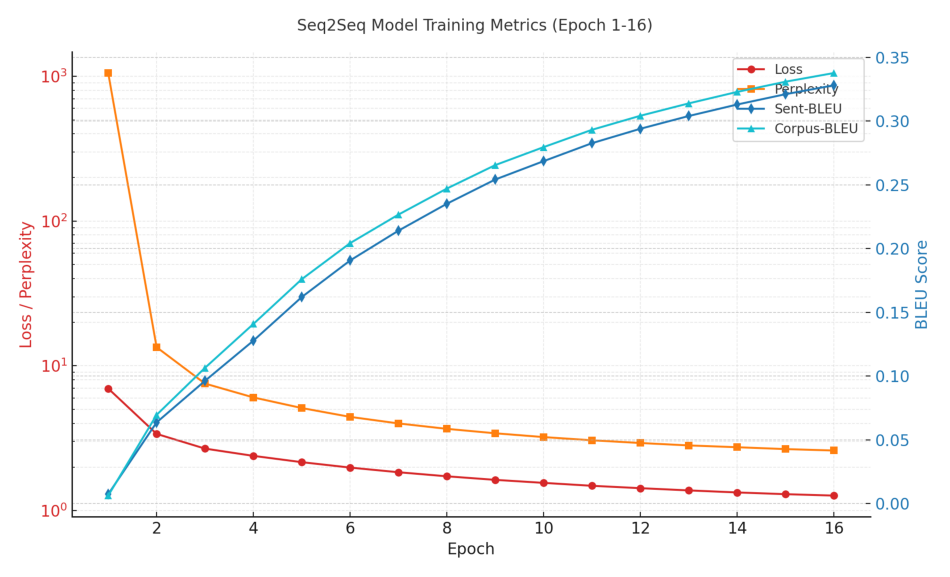

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Fotoğrafın yolu
image_path = r"C:\Users\hdgn5\OneDrive\Masaüstü\PyTorch - Transformers  - LLM\LLM & Transformers\LLM - Uygulama\metrics.png"

# Fotoğrafı yükle
img = mpimg.imread(image_path)

# Görüntüyü büyüt (örnek: 12x8 inç)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')  # Eksenleri gizle
plt.show()
